**Lab 9 – Image processing with Convolutional Neural Networks**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/09_Convolutional_NeuralNetworks_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/09_Convolutional_NeuralNetworks_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# 🛠️ Setup

In [ ]:
# @title Install packages
!apt-get install tree -qq
!pip install git+https://github.com/cleanlab/cleanvision.git -qq
!pip install cleanlab -qq
!pip install scikeras -qq

Selecting previously unselected package tree.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 9.5 MB/s eta 0:00:00


We need to restart the environment after installing.

In [ ]:
# @title Import packages
# Python ≥3.7 is recommended
import sys
assert sys.version_info >= (3, 7)
import os
from pathlib import Path
from time import strftime

# Scikit-Learn ≥1.01 is recommended
from packaging import version
import sklearn
from sklearn.datasets import load_sample_image
from sklearn.datasets import load_sample_images
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Tensorflow ≥2.8.0 is recommended
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import optimizers
#from keras_segmentation.models.unet import vgg_unet
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Image augmentation
import albumentations as A

# Data centric AI
from cleanvision.imagelab import Imagelab
from cleanlab.filter import find_label_issues
from scikeras.wrappers import KerasClassifier, KerasRegressor

# Common imports
import numpy as np
import os
import shutil
import pathlib
import resource
from functools import partial
import tqdm
import cv2

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        plt.title(f"id: {id} \n label: {labels[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 📘 What is a Convolution?

A neuron's weights can be represented as a small image the size of the receptive field. For example, below shows two possible sets of weights, called filters (or convolution kernels). In TensorFlow, each input image is typically represented as a 3D tensor of shape `[height, width, channels]`. A mini-batch is represented as a 4D tensor of shape `[mini-batch size, height, width, channels]`. The weights of a convolutional layer are represented as a 4D tensor of shape `[fh, fw, fn', fn]`. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape `[fn]`.

> 📌 In Pytorch, a mini-batch is represented as a 4D tensor of shape `[mini-batch size, channels, height, width]`. PyTorch uses a channels-first format for images and Tensorflow use channels-last format.

Let’s look at a simple example. The following code loads two sample images, using Scikit-Learn’s [`load_sample_images()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_sample_image.html) (which loads two color images, one of a Chinese temple, and the other of a flower). The pixel intensities (for each color channel) is represented as a byte from 0 to 255, so we scale these features simply by dividing by 255, to get floats ranging from 0 to 1. Then we create two `7 × 7` filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle).

In [ ]:
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) # [height, width, channel of inputs, channel of feature maps]
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line
images.shape

(2, 427, 640, 3)

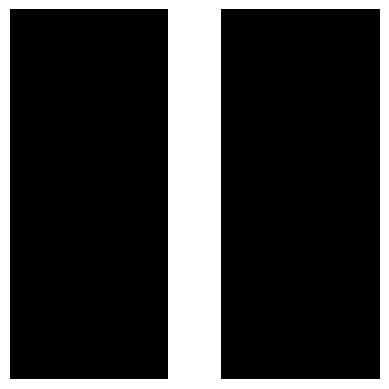

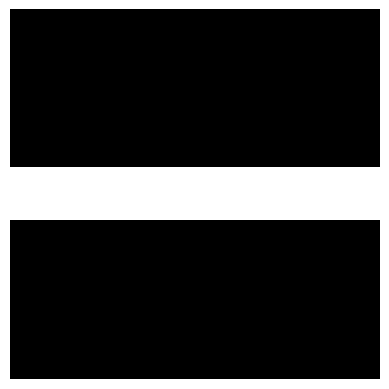

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])

Now if all neurons in a layer use the same vertical line filter (and the same bias term), and you feed the network with the image, the
layer will output a feature maps. Here, we apply them to both images using the `tf.nn.conv2d()` function, which is part of TensorFlow’s low-level Deep Learning API. In this example, we use zero padding (`padding="SAME"`) and a stride of 1

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since `padding="SAME"` and `strides=1`, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
outputs.shape # [batches, height, width, channel of feature maps]

TensorShape([2, 427, 640, 2])

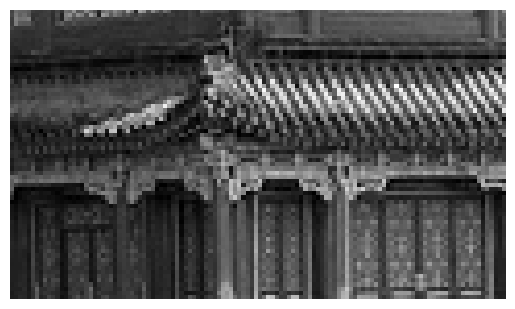

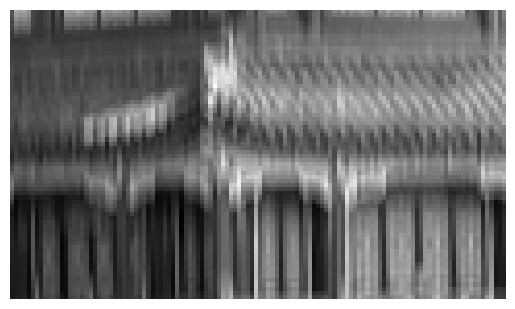

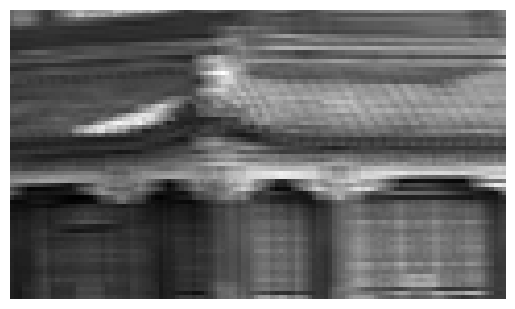

In [ ]:
def crop(images):
    return images[150:220, 130:250] #crop for better visulization

plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

Notice that the vertical white lines get enhanced in one feature map while the rest gets blurred. Similarly, the other feature map is what you get if all neurons use the same horizontal line filter; notice that the horizontal white lines get enhanced while the rest is blurred out. Thus, a layer full of neurons using the same filter outputs a feature map, which highlights the areas in an image that activate the filter the most. Of course you do not have to define the filters manually: instead, during training the convolutional layer will **automatically learn the most useful filters** for its task, and the layers above will learn to combine them into more complex patterns.

# 📘 Convolutional Layer

Instead of manually creating the variables, however, you can simply use the `tf.keras.layers.Conv2D` layer. The code below creates a Conv2D layer with 32 filters, each `7 × 7`, using a stride of 1 (both horizontally and vertically), VALID padding, and applying the linear activation function to its outputs. As you can see, convolutional layers have quite a few hyperparameters: you must choose the number of filters, their height and width, the strides, and the padding type. As always, you can use cross-validation to find the right hyperparameter values, but this is very time-consuming. We will discuss common CNN architectures later, to give you some idea of what hyperparameter values work best in practice.

In [ ]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images) # Functional API
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)
images.shape

TensorShape([2, 70, 120, 3])

Let's call this layer, passing it the two test images:

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

In [ ]:
conv_layer.get_config()

{'name': 'conv2d',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'filters': 32,
 'kernel_size': (7, 7),
 'strides': (1, 1),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

The height and width have both shrunk by 6 pixels. This is due to the fact that the Conv2D layer does not use any zero-padding by default, which means that we lose a few pixels on the sides of the output feature maps, depending on the size of the filters. Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:

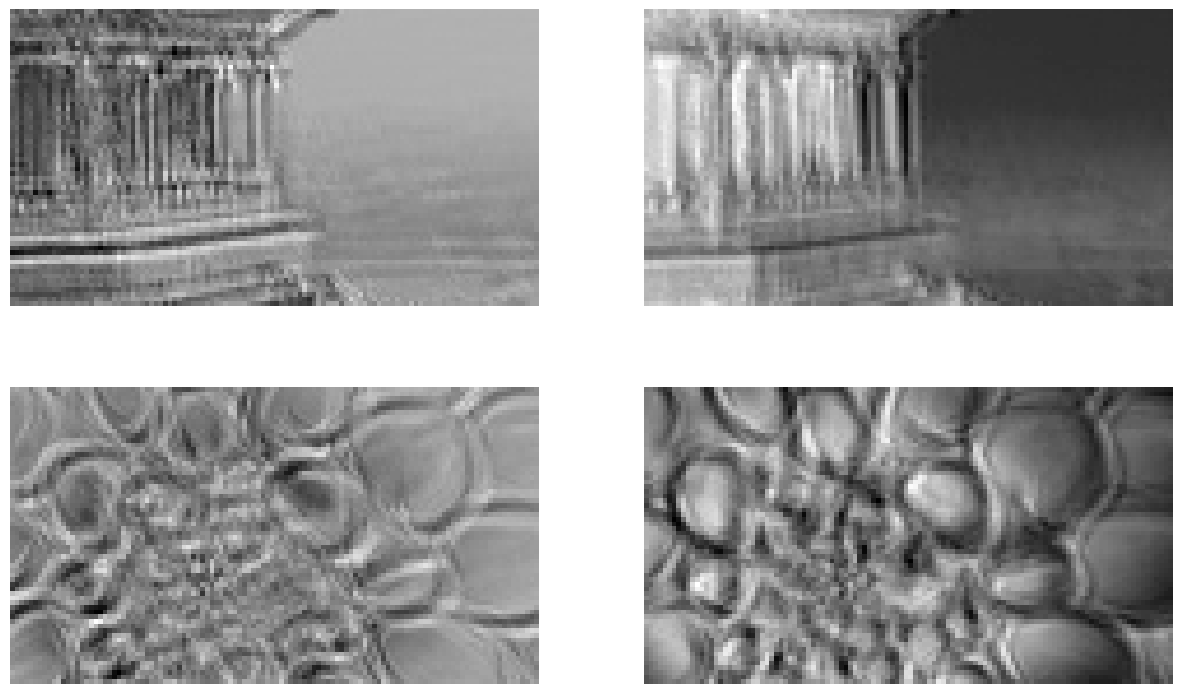

In [ ]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters **typically act like edge detectors**, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

If instead we set `padding="same"`, then the inputs are padded with enough zeros on all sides to ensure that the output feature maps end up with the same size as the inputs (hence the name of this option):

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

If the stride is greater than 1 (in any direction), then the output size will not be equal to the input size, even if `padding="same"`. For example, if you set `strides=2` (or equivalently `strides=(2, 2)`), then the output feature maps will be `35 × 60`:

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [ ]:
# @title Compute size of feature map and size of padding
# This utility function can be useful to compute the size of the
# feature maps output by a convolutional layer. It also returns
# the number of ignored rows or columns if padding="valid", or the
# number of zero-padded rows or columns if padding="same".

kernel_size = 7  #@param {type: "number"}
strides = 1  #@param {type: "number"}
padding = "valid"  #@param ['valid', 'same']

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=kernel_size, strides=strides, padding=padding)

(array([ 64, 114]), array([0, 0]))

Just like a Dense layer, a Conv2D layer holds all the layer’s weights, including
the kernels and biases. The kernels are initialized randomly, while the biases are initialized to zero. These weights are accessible as TF variables via the `weights` attribute, or as `NumPy` arrays via the `get_weights()` method:

In [ ]:
kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape

((7, 7, 3, 32), (32,))

You can find other useful kernels here https://setosa.io/ev/image-kernels/

# 📘 Pooling layer

## Max pooling

Implementing a max pooling layer in TensorFlow is quite easy. The following code
creates a max pooling layer using a 2 × 2 kernel. **The strides default to the kernel size**, so this layer will use a stride of 2 (both horizontally and vertically). By default, it uses VALID padding (i.e., no padding at all):

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(images)

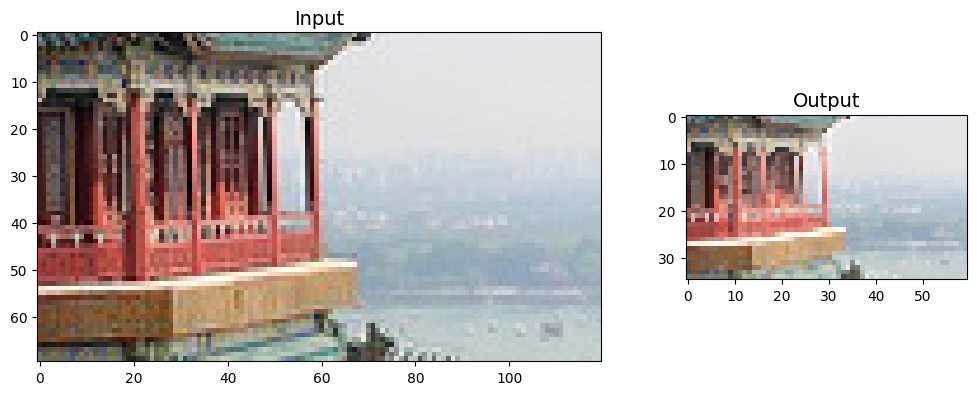

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
plt.show()

## Average pooling

To create an average pooling layer, just use `AvgPool2D` instead of `MaxPool2D`. As you might expect, it works exactly like a max pooling layer, except it computes the mean rather than the max.

In [ ]:
avg_pool = tf.keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output = avg_pool(images)

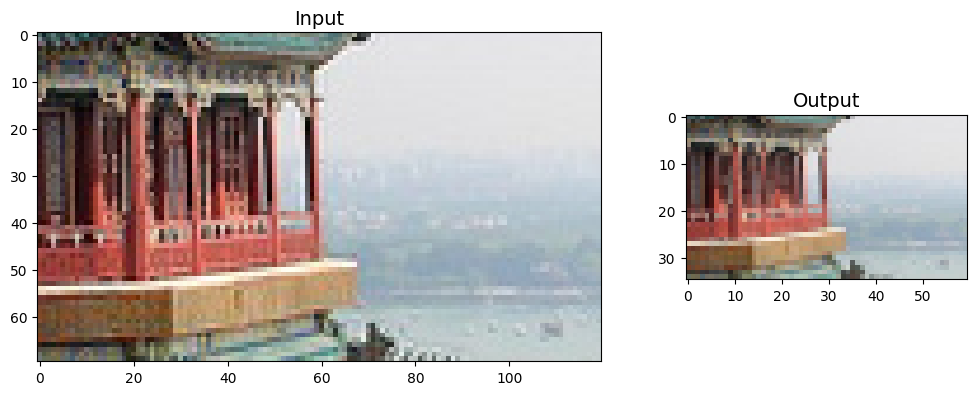

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
plt.show()

## 🔍 Depthwise pooling

Note that max pooling and average pooling can be performed along the depth
dimension instead of the spatial dimensions, although it’s not as common. This can allow the CNN to learn to be invariant to various features. For example, it could learn multiple filters, each detecting a different rotation of the same pattern, and the depthwise max pooling layer would ensure that the output is the same regardless of the rotation. The CNN could similarly learn to be invariant to anything: thickness, brightness, skew, color, and so on.

Keras does not include a depthwise max pooling layer, but it’s not too difficult to implement a custom layer for that:

In [ ]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

(2, 70, 120, 1)


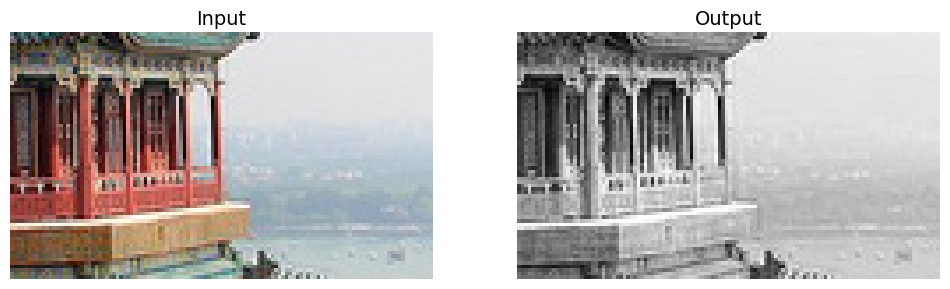

In [ ]:
depth_output = DepthPool(pool_size=3)(images)

print(depth_output.shape)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

## 🔍 Global Average Pooling

One last type of pooling layer that you will often see in modern architectures is the global average pooling layer. It works very differently: all it does is compute the mean of each entire feature map (it’s like an average pooling layer using a pooling kernel with the same spatial dimensions as the inputs). **This means that it just outputs a single number per feature map and per instance.** Although this is of course extremely destructive (most of the information in the feature map is lost), it can be useful as the output layer. To create such a layer, simply use the `tf.keras.layers.GlobalAvgPool2D` class:

In [ ]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

In [ ]:
# It is the same as using low level API to perform reduction
global_avg_pool = tf.keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

Now you know all the building blocks to create a convolutional neural network. Let’s see how to assemble them.

# 📘 Tackling Fashion MNIST With a CNN

Before delving into the code, you can go through https://poloclub.github.io/cnn-explainer/ to make sure you understand every piece of CNN.

Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on. The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e.,with more feature maps) thanks to the convolutional layers. At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

<p align="center">
<img src="https://drive.google.com/uc?id=1YkH7CqpyOWOuakvS8Ywj0m5t9SjfxoAe" alt="drawing" width="600"/>
</p>

Here is how you can implement a simple CNN to tackle the fashion MNIST dataset

In [ ]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_train.shape, X_valid.shape, X_test.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal"
)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),  # Define the input shape here
    DefaultConv2D(filters=32, kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=32, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In this code, we start by using the `partial()` function to define a thin wrapper around the `Conv2D` class, called `DefaultConv2D`: it simply avoids having to repeat the same hyperparameter values over and over again.

* The first layer sets `shape=[28, 28, 1]`, which means the images are 28 × 28 pixels, with a single color channel (i.e., grayscale).
* Next, we have a max pooling layer, which divides each spatial dimension by a factor of two (since `pool_size=2`).
* Then we repeat the same structure twice: convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several times (the number of repetitions is a hyperparameter you can tune).
* Note that the number of filters grows as we climb up the CNN towards the output layer (it is initially 32, then 64, then 128): it makes sense for it to grow in the image setting, since the number of low level features is often fairly low (e.g., small circles, horizontal lines, etc.), but there are many different ways to combine them into higher level features. **It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2**, we can afford doubling the number of feature maps in the next layer, without fear of exploding the number of parameters, memory usage, or computational load.
* Next is the fully connected network, composed of 1 hidden dense layers and a dense output layer. **Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance**. We also add two dropout layers, with a dropout rate of 50% each, to reduce overfitting.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,666 (1.35 MB)

 Trainable params: 354,666 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.4468 - loss: 1.4908 - val_accuracy: 0.8044 - val_loss: 0.5584
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7311 - loss: 0.7130 - val_accuracy: 0.8492 - val_loss: 0.4865
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7797 - loss: 0.6089 - val_accuracy: 0.8692 - val_loss: 0.3770
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8109 - loss: 0.5242 - val_accuracy: 0.8738 - val_loss: 0.3800
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8358 - loss: 0.4890 - val_accuracy: 0.8842 - val_loss: 0.3305
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8452 - loss: 0.4591 - val_accuracy: 0.8924 - val_loss: 0.3125
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8588 - loss: 0.4250 - val_accuracy: 0.8884 - val_loss: 0.3204
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8639 - loss: 0.4162 -

In [ ]:
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

score, y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8953 - loss: 0.4133
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


([0.3808043599128723, 0.8931999802589417],
 array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 3.0793707e-30, 0.0000000e+00, 2.8119389e-08,
         0.0000000e+00, 1.0000000e+00],
        [5.1588952e-03, 1.0268907e-10, 9.8514992e-01, 1.9245259e-12,
         1.3985302e-03, 2.6591040e-41, 8.2926610e-03, 0.0000000e+00,
         6.2812877e-20, 6.7630926e-29],
        [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 4.6361960e-41,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 3.2229865e-44,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [4.4077352e-01, 2.9180793e-08, 5.5873854e-04, 6.2607709e-05,
         1.5866208e-05, 7.5672897e-12, 5.5858916e-01, 4.9133529e-22,
         6.0249484e-08, 8.1493588e-12],
        [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 7.1227199e-33

This CNN reaches about 90% accuracy on the test set. It’s not the [state of the art](https://paperswithcode.com/sota/image-classification-on-fashion-mnist), but it is pretty good and better than the dense network with similar number of parameters!

# 📘 Training a convnet from scratch on a small dataset

Having to train an image-classification model using **very little data is a common situation, which you’ll likely encounter in practice** if you ever do computer vision in a professional context. A “few” samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats in a dataset containing 5,000 pictures of cats and dogs (2,500 cats, 2,500 dogs). We’ll use 2,000 pictures for training, 1,000 for validation, and 2,000 for testing.

In this section, we’ll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. We’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of about 70%. At that point, the main issue will be overfitting. Then we’ll introduce data augmentation, a powerful technique for mitigating overfitting in computer vision. By using data augmentation, we’ll improve the model to reach an accuracy of 80–85%.

## The relevance of deep learning for small-data problems

What qualifies as “enough samples” to train a model is relative— relative to the size and depth of the model you’re trying to train, for starters. It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples, **but a few hundred can potentially suffice if the model is small and well regularized and the task is simple.**

Because convnets learn local, translation-invariant features, they’re highly data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You’ll see this in action in this section.

## Downloading the data

The Dogs vs. Cats dataset that we will use isn’t packaged with Keras. It was made available by Kaggle as part of a computer vision competition in late 2013, back when convnets weren’t mainstream. You can download the original dataset from [www.kaggle.com/c/dogs-vs-cats/data](www.kaggle.com/c/dogs-vs-cats/data).

But you can also use Kaggle API. First, you need to create a Kaggle API key and download it to your local machine. Just navigate to the Kaggle website in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine.

<p align="center">
<img src="https://drive.google.com/uc?id=1Yo0bW4A59Se1EbE50JZMiWNueErB2eJa" alt="drawing" width="600"/>
</p>

In [ ]:
# @title Upload json and Downalod data
# Upload the API’s key JSON file to your Colab
# session by running the following code in a notebook cell:
from google.colab import files
files.upload();

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
 99% 803M/812M [00:03<00:00, 314MB/s]
100% 812M/812M [00:03<00:00, 271MB/s]


The first time you try to download the data, you may get a “403 Forbidden” error. That’s because you need to accept the terms associated with the dataset before you download it—you’ll have to go to www.kaggle.com/c/dogs-vs-cats/rules (while logged into your Kaggle account) and click the I Understand and Accept button. You only need to do this once.

The pictures in our dataset are medium-resolution color JPEGs. Unsurprisingly, the original dogs-versus-cats Kaggle competition, all the way back in 2013, was won by entrants who used convnets. The best entries achieved up to 95%
accuracy. Even though we will train our models on less than 10% of the data that was available to the competitors, we will still get a resonable well performance.

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing the data, we’ll create
a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1,000 samples of each class. Why do this? **Because many of the image datasets you’ll encounter in your career only contain a few thousand samples**, not tens of thousands. Having more data
available would make the problem easier, so it’s good practice to learn with a small dataset.

In [ ]:
!tree train | (head -n 10; echo "..."; tail -n 10)

train
├── cat.0.jpg
├── cat.10000.jpg
├── cat.10001.jpg
├── cat.10002.jpg
├── cat.10003.jpg
├── cat.10004.jpg
├── cat.10005.jpg
├── cat.10006.jpg
├── cat.10007.jpg
...
├── dog.9995.jpg
├── dog.9996.jpg
├── dog.9997.jpg
├── dog.9998.jpg
├── dog.9999.jpg
├── dog.999.jpg
├── dog.99.jpg
└── dog.9.jpg

0 directories, 25000 files


In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
!tree cats_vs_dogs_small -L 2

cats_vs_dogs_small
├── test
│   ├── cat
│   └── dog
├── train
│   ├── cat
│   └── dog
└── validation
    ├── cat
    └── dog

9 directories, 0 files


We now have 2,000 training images, 1,000 validation images, and 2,000 test images. Each split contains the same number of samples from each class: **this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.**

## Building the model

The convnet will be a stack of alternated `Conv2D` (with relu activation) and `MaxPooling2D` layers. But because we’re dealing with bigger images and a more complex problem, we’ll make our model larger, accordingly: it will have two more `Conv2D` and `MaxPooling2D` stages. This serves both to augment the capacity of the model and to further reduce the
size of the feature maps **so they aren’t overly large when we reach the Flatten layer**.

Here, because we start from inputs of size `180 pixels × 180 pixels`, we end up with feature maps of size `7 × 7` just before the Flatten layer. Because we’re looking at a binary-classification problem, we’ll end the model with a
single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the model is looking at one class or the other.

One last small difference: we will start the model with a Rescaling layer, which will rescale image inputs (whose values are originally in the `[0, 255]` range) to the `[0, 1]` range.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

inputs = tf.keras.Input(shape=(180, 180, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# For the compilation step, we’ll go with the nadam optimizer. Because we
# ended the model with a single sigmoid unit, we’ll use binary crossentropy as the loss
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

## Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Resize them to a shared size (we’ll use 180 × 180).
5. Pack them into batches (we’ll use batches of 32 images).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. In particular, Keras features the utility function `image_dataset_from_directory()`, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors. This is what we’ll use here.

Calling `image_dataset_from_directory(directory)` will first list the subdirectories of directory and assume each one contains images from one of our classes. It will then index the image files in each subdirectory. Finally, it will create and return a `tf.data.Dataset` object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

In [ ]:
seed = 2024
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    shuffle=True,
    batch_size=32,
    seed=seed)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    shuffle=False,
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    shuffle=False,
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Keras data loading utilities, located in `keras.utils`, help you go from raw data on disk to a `tf.data.Dataset` object that can be used to efficiently train a model.

A Dataset object is an iterator: you can use it in a for loop. It will typically return batches of input data and labels. You can pass a Dataset object directly to the `fit()` method of a Keras model. The Dataset class handles many key features that would otherwise be cumbersome to implement yourself—in particular, asynchronous data prefetching (preprocessing the next batch of data while the previous one is being handled by the model, which keeps execution flowing without interruptions).

[https://keras.io/api/data_loading/](https://keras.io/api/data_loading/)

Let’s look at the output of one of these Dataset objects: it yields batches of `180 × 180` RGB images (shape `(32, 180, 180, 3)`) and integer labels (shape `(32,)`). There are 32 samples in each batch (the batch size).

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Fitting the model

Let’s fit the model on our dataset. We’ll use the validation_data argument in `fit()` to monitor validation metrics on a separate Dataset object.

Note that we’ll also use a `ModelCheckpoint` callback to save the model after each epoch. We’ll configure it with the path specifying where to save the file, as well as the
arguments `save_best_only=True` and `monitor="val_loss"`: they tell the callback to only save a new file (overwriting any previous one) when the current value of the val_loss metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its bestperforming training epoch, in terms of its performance on the validation data. As a result, we won’t have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.4879 - loss: 0.7071 - val_accuracy: 0.5010 - val_loss: 0.6919
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5596 - loss: 0.6879 - val_accuracy: 0.5780 - val_loss: 0.6712
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6452 - loss: 0.6522 - val_accuracy: 0.5440 - val_loss: 0.7328
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6775 - loss: 0.6110 - val_accuracy: 0.6990 - val_loss: 0.5830
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7133 - loss: 0.5904 - val_accuracy: 0.7070 - val_loss: 0.5804
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7576 - loss: 0.5133 - val_accuracy: 0.6880 - val_loss: 0.5806
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7736 - loss: 0.4707 - val_accuracy: 0.7120 - val_loss: 0.6066
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8066 - loss: 0.4239 - val_accuracy: 0.6880 - 

Let’s plot the loss and accuracy of the model over the training and validation data during training

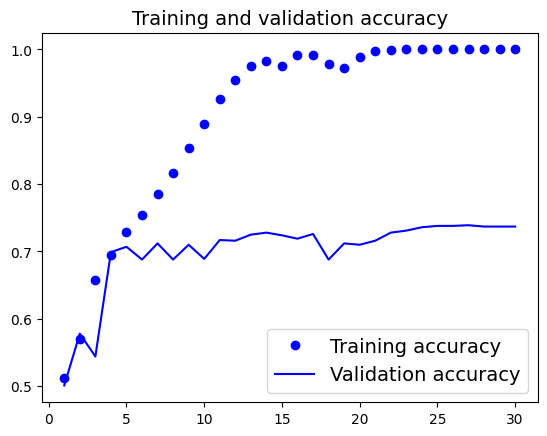

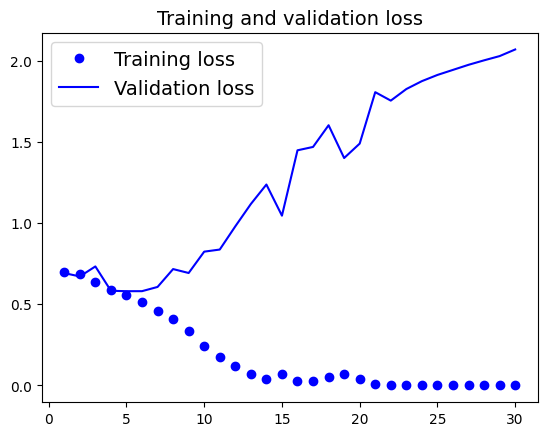

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

These plots **are characteristic of overfitting**. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 74%. The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds.

Let’s check the test accuracy. We’ll reload the model from its saved file to evaluate it as it was before it started overfitting.

In [ ]:
test_model = tf.keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6751 - loss: 0.6492
Test accuracy: 0.708


We get a test accuracy of about 70%. Because we have relatively few training samples (2,000), overfitting will be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now
going to work with a new one, specific to computer vision and used almost universally when processing images with deep learning models: data augmentation.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images.

The goal is that, at training time, your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data so it can generalize better.
In Keras, **this can be done by adding a number of data augmentation layers at the start of your model**. Let’s get started with an example: the following Sequential model chains several random image transformations. In our model, we’d include it right before the `Rescaling` layer.

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

Let’s quickly go over this code:
* `RandomFlip("horizontal")`—Applies horizontal flipping to a random 50% of the images that go through it
* `RandomRotation(0.1)`—Rotates the input images by a random value in the range `[–10%, +10%]` (these are fractions of a full circle—in degrees, the range would be `[–36 degrees, +36 degrees]`)
* `RandomZoom(0.2)`—Zooms in or out of the image by a random factor in the range `[-20%, +20%]`

[https://keras.io/api/layers/preprocessing_layers/image_augmentation/](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)

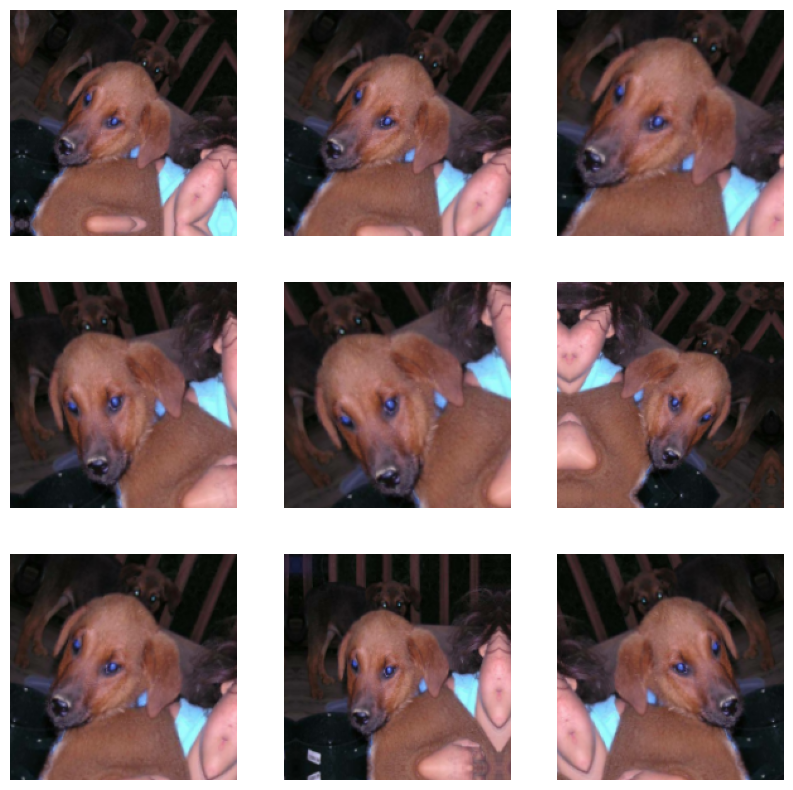

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1): #Sample 1 batch from the dataset
    for i in range(9):
      # During inference time, the output will be identical to input.
      # Call the layer with training=True to flip the input.
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

On the other hand, we can also use [albumentations](https://albumentations.ai/) for data augmentation:

In [ ]:
# Batch size set to 1
seed = 2024
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    shuffle=True,
    batch_size=1,
    seed=seed)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    shuffle=False,
    batch_size=1)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    shuffle=False,
    batch_size=1)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
batch_size = 32
image_size = 180
AUTOTUNE = tf.data.experimental.AUTOTUNE

def augment_train_data(train_ds):
    transforms = A.Compose([
            A.HorizontalFlip(),
            A.ShiftScaleRotate(shift_limit=0, scale_limit=0.20, rotate_limit=36, p=.5),
            ])

    def aug_fn(image):
        # For opencv convention
        image = image.astype(np.uint8)
        data = {"image":image.squeeze()}
        # Passes the contents of the data dictionary as keyword arguments
        aug_data = transforms(**data)
        aug_img = aug_data["image"]
        # Back to keras
        aug_img = tf.cast(aug_img/255.0, tf.float32)
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label

    def set_shapes(img, label, img_shape=(image_size,image_size,3)):
        img.set_shape(img_shape)
        label.set_shape([1,])
        return img, label

    ds_alb = train_ds.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE)
    ds_alb = ds_alb.batch(batch_size) # Return to original batch size here
    return ds_alb

def augment_val_data(val_ds):

    def aug_fn(image):
        image = image.astype(np.uint8)
        aug_data = {"image":image.squeeze()}
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img/255.0, tf.float32)
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label

    def set_shapes(img, label, img_shape=(image_size, image_size,3)):
        img.set_shape(img_shape)
        label.set_shape([1,])
        return img, label

    ds_alb = val_ds.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(batch_size)
    return ds_alb

> 📌 Note that we do not apply augmentation on validation/testing data!

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_alb = augment_train_data(train_dataset)
val_alb = augment_val_data(validation_dataset)
test_alb = augment_val_data(test_dataset)

In [ ]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

view_image(train_alb)

Output hidden; open in https://colab.research.google.com to view.

If we train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can’t produce new information; we can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, we’ll also add a Dropout layer to our model right before the densely connected classifier.

One last thing you should know about random image augmentation layers: just like Dropout, they’re inactive during inference (when we call `predict()` or `evaluate()`).
During evaluation, our model will behave just the same as when it did not include data augmentation and dropout.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

inputs = tf.keras.Input(shape=(180, 180, 3))
#x = data_augmentation(inputs)
#x = tf.keras.layers.Rescaling(1./255)(x)
x = inputs
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

Let’s train the model using data augmentation and dropout. **Because we expect overfitting to occur much later during training**, we will train for two times as many
epochs—50.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_alb, # Use the dataset from albumentations
    epochs=50,
    validation_data=val_alb,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.4992 - loss: 0.6996 - val_accuracy: 0.5010 - val_loss: 0.6920
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5310 - loss: 0.6926 - val_accuracy: 0.6110 - val_loss: 0.6691
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6286 - loss: 0.6642 - val_accuracy: 0.6670 - val_loss: 0.6166
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6659 - loss: 0.6221 - val_accuracy: 0.6790 - val_loss: 0.5941
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6845 - loss: 0.6001 - val_accuracy: 0.7230 - val_loss: 0.5647
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7303 - loss: 0.5631 - val_accuracy: 0.7330 - val_loss: 0.5219
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7318 - loss: 0.5327 - val_accuracy: 0.7420 - val_loss: 0.5248
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7555 - loss: 0.4923 - val_accuracy: 0.7750 -

Let’s plot the results again: Thanks to data augmentation and dropout, we start overfitting much later, around epochs 20–30 (compared to epoch 10 for the original model). The validation accuracy ends up consistently in the 80–85% range—a big improvement over our first try.

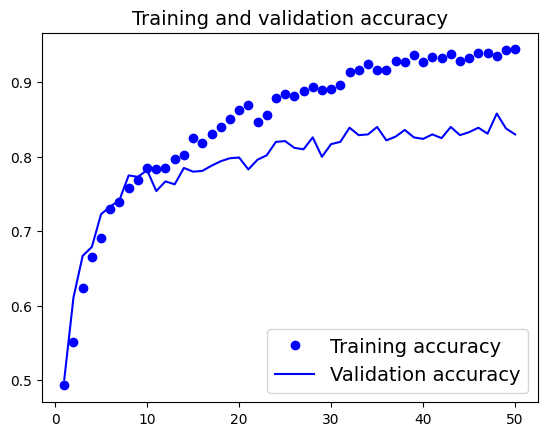

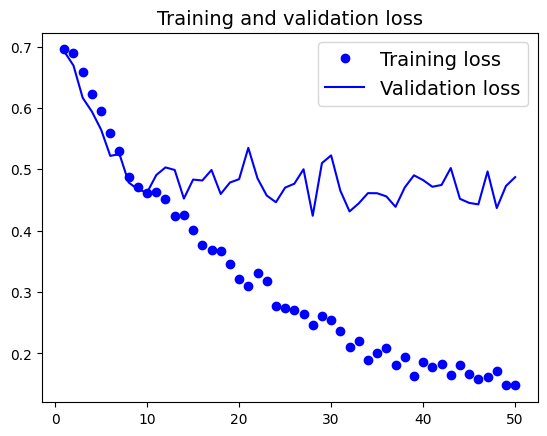

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Let’s check the test accuracy.

In [ ]:
test_model = tf.keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_alb)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8091 - loss: 0.4641
Test accuracy: 0.794


We get a test accuracy for about 80%. It’s starting to look good! By further tuning the model’s configuration (such as the number of filters per convolution layer, or the number of layers in the model), we might be able to get an even better accuracy, likely up to 90%. But it would prove difficult to go any higher just by training our own convnet from scratch, because we have so little data to work
with. As a next step to improve our accuracy on this problem, we’ll have to use a pretrained model as we will see later on.

# 🔍 Object Detection with `KerasCV` (Optional)

Checkout https://keras.io/guides/keras_cv/object_detection_keras_cv/#object-detection-introduction for more details.

# 🔍 Image segmentation with Keras (Optional)

Checkout https://keras.io/guides/keras_cv/semantic_segmentation_deeplab_v3_plus/ and https://keras.io/guides/keras_cv/segment_anything_in_keras_cv/ for more details.

📌 Popular pretrained models are frequently becoming multi-modal. In the text domain, chat LLMs are adding support for image and audio inputs and outputs. In the vision domain, using text encoders is common for a wide range of tasks from image segmentation to image generation. To that end, we are consolidating KerasNLP and KerasCV into a KerasHub package. See https://github.com/keras-team/keras-hub/issues/1831.

# 📘 Data cleaning with `CleanVision`

`CleanVision` is built to automatically detects various issues in image datasets. This data-centric AI package is designed as a quick first step for any computer vision project to find problems in your dataset, which you may want to address before applying machine learning. The following **Issue Key** column specifies the name for each type of issue in `CleanVision` code.

|     | Issue Type      | Description                                                                                  | Issue Key        |
|-----|------------------|----------------------------------------------------------------------------------------------|------------------|
| 1   | Light            | Images that are too bright/washed out in the dataset                                         | light            |
| 2   | Dark             | Images that are irregularly dark                                                             | dark             |
| 3   | Odd Aspect Ratio | Images with an unusual aspect ratio (i.e. overly skinny/wide)                                                       | odd_aspect_ratio |
| 4   | Exact Duplicates | Images that are exact duplicates of each other                          | exact_duplicates |
| 5   | Near Duplicates  | Images that are almost visually identical to each other (e.g. same image with different filters)                                 | near_duplicates  |
| 6   | Blurry           | Images that are blurry or out of focus                                                  | blurry           |
| 7   | Grayscale        | Images that are grayscale (lacking color)                                                            | grayscale        |
| 8   | Low Information  | Images that lack much information (e.g. a completely black image with a few white dots) | low_information  |
| 9   | Odd Size | Images that are abnormally large or small compared to the rest of the dataset | odd_size |

In [ ]:
!wget - nc 'https://cleanlab-public.s3.amazonaws.com/CleanVision/image_files.zip'
!unzip -q image_files.zip

--2024-11-10 05:05:17--  http://-/
Resolving - (-)... failed: Name or service not known.
wget: unable to resolve host address ‘-’
--2024-11-10 05:05:17--  http://nc/
Resolving nc (nc)... failed: No address associated with hostname.
wget: unable to resolve host address ‘nc’
--2024-11-10 05:05:18--  https://cleanlab-public.s3.amazonaws.com/CleanVision/image_files.zip
Resolving cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)... 52.217.50.60, 52.216.110.67, 3.5.8.190, ...
Connecting to cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)|52.217.50.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82341589 (79M) [application/zip]
Saving to: ‘image_files.zip’

image_files.zip     100%[===================>]  78.53M  45.9MB/s    in 1.7s    

2024-11-10 05:05:20 (45.9 MB/s) - ‘image_files.zip’ saved [82341589/82341589]

FINISHED --2024-11-10 05:05:20--
Total wall clock time: 2.3s
Downloaded: 1 files, 79M in 1.7s (45.9 MB/s)


## 1. Using `CleanVision` to detect issues in your dataset

Reading images from /content/image_files
Sample images from the dataset


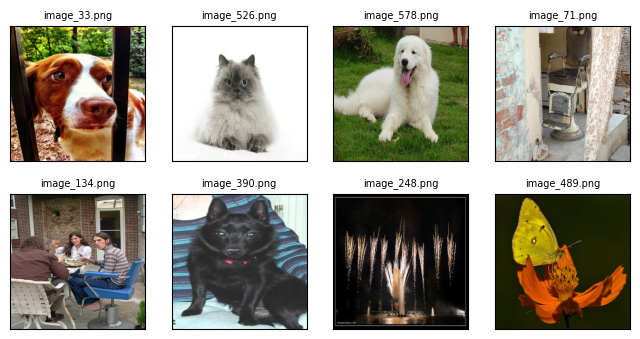

In [ ]:
# Path to your dataset, you can specify your own dataset path
dataset_path = "./image_files/"

# Initialize imagelab with your dataset
imagelab = Imagelab(data_path=dataset_path)

# Visualize a few sample images from the dataset
imagelab.visualize(num_images=8)

In [ ]:
# Find issues
# You can also specify issue types to detect, for example
# issue_types = {"dark": {"threshold": 0.2}}
# imagelab.find_issues(issue_types)
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/607 [00:00<?, ?it/s]

  0%|          | 0/607 [00:00<?, ?it/s]

Issue checks completed. 205 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


The `report()` method helps you quickly understand the major issues detected in the dataset. It reports the number of images in the dataset that exhibit each type of issue, and shows example images corresponding to the most severe instances of each issue.

Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | odd_size         |          109 |
|  1 | near_duplicates  |           20 |
|  2 | grayscale        |           20 |
|  3 | exact_duplicates |           19 |
|  4 | odd_aspect_ratio |           11 |
|  5 | dark             |           10 |
|  6 | blurry           |            6 |
|  7 | low_information  |            5 |
|  8 | light            |            5 | 

--------------------- odd_size images ----------------------

Number of examples with this issue: 109
Examples representing most severe instances of this issue:



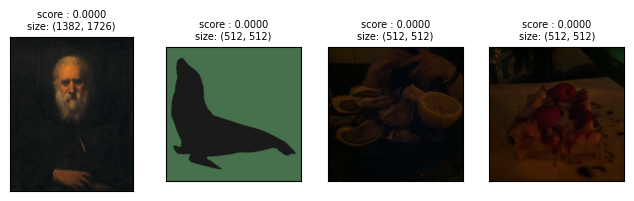

------------------ near_duplicates images ------------------

Number of examples with this issue: 20
Examples representing most severe instances of this issue:

Set: 0


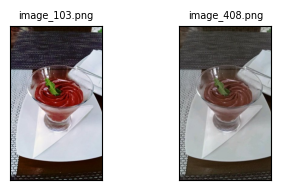

Set: 1


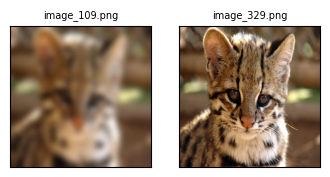

Set: 2


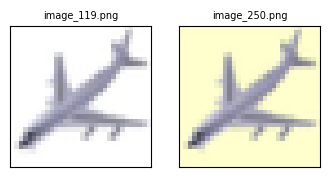

Set: 3


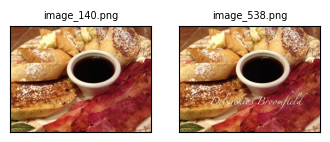

--------------------- grayscale images ---------------------

Number of examples with this issue: 20
Examples representing most severe instances of this issue:



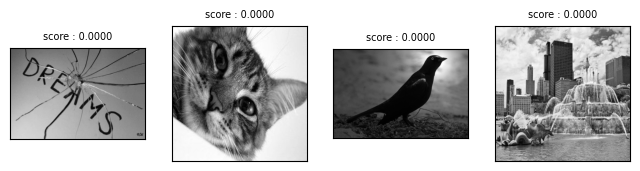

----------------- exact_duplicates images ------------------

Number of examples with this issue: 19
Examples representing most severe instances of this issue:

Set: 0


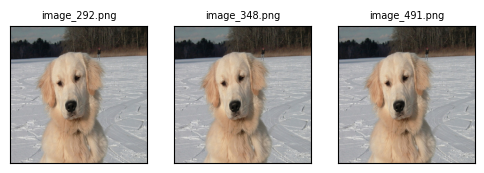

Set: 1


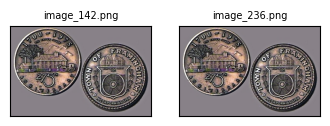

Set: 2


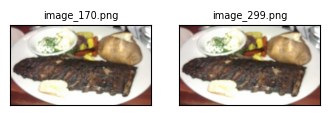

Set: 3


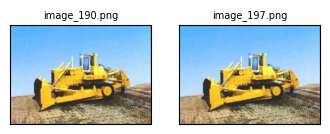

----------------- odd_aspect_ratio images ------------------

Number of examples with this issue: 11
Examples representing most severe instances of this issue:



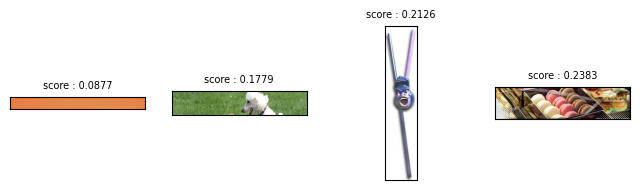

----------------------- dark images ------------------------

Number of examples with this issue: 10
Examples representing most severe instances of this issue:



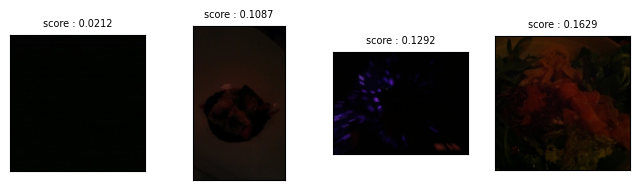

---------------------- blurry images -----------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:



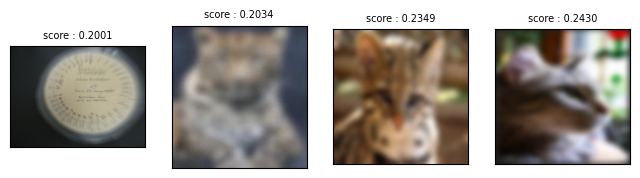

------------------ low_information images ------------------

Number of examples with this issue: 5
Examples representing most severe instances of this issue:



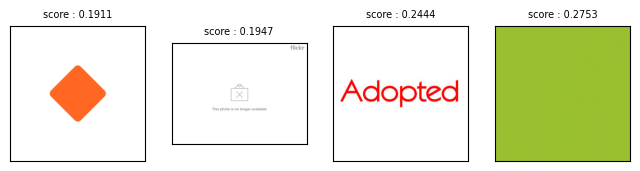

----------------------- light images -----------------------

Number of examples with this issue: 5
Examples representing most severe instances of this issue:



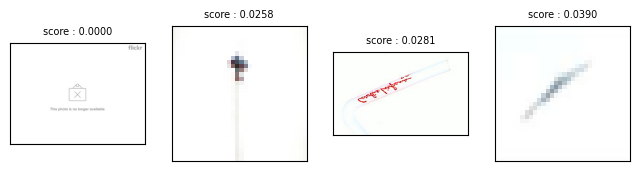

In [ ]:
imagelab.report()

The main way to interface with your data is via the `Imagelab` class. This class can be used to understand the issues in your dataset at a high level (global overview) and low level (issues and quality scores for each image) as well as additional information about the dataset. It has three main attributes:

- `Imagelab.issue_summary`
- `Imagelab.issues`
- `Imagelab.info`

### `imagelab.issue_summary`

`Dataframe`  with global summary of all issue types detected in your dataset and the overall prevalence of each type.

In each row:
- `issue_type` - name of the issue
- `num_images` - number of images of that issue type found in the dataset

In [ ]:
imagelab.issue_summary

,issue_type,num_images
0,odd_size,109
1,near_duplicates,20
2,grayscale,20
3,exact_duplicates,19
4,odd_aspect_ratio,11
5,dark,10
6,blurry,6
7,low_information,5
8,light,5


### `imagelab.issues`

`Dataframe`  assessing each image in your dataset, reporting which issues each image exhibits and a quality score for each type of issue.

In [ ]:
imagelab.issues

,odd_size_score,is_odd_size_issue,odd_aspect_ratio_score,is_odd_aspect_ratio_issue,low_information_score,is_low_information_issue,light_score,is_light_issue,grayscale_score,is_grayscale_issue,dark_score,is_dark_issue,blurry_score,is_blurry_issue,exact_duplicates_score,is_exact_duplicates_issue,near_duplicates_score,is_near_duplicates_issue
/content/image_files/image_0.png,1.0,False,1.0,False,0.806332,False,0.925490,False,1,False,1.000000,False,0.980373,False,1.0,False,1.0,False
/content/image_files/image_1.png,1.0,False,1.0,False,0.923116,False,0.906609,False,1,False,0.990676,False,0.472314,False,1.0,False,1.0,False
/content/image_files/image_10.png,1.0,False,1.0,False,0.875129,False,0.995127,False,1,False,0.795937,False,0.470706,False,1.0,False,1.0,False
/content/image_files/image_100.png,1.0,False,1.0,False,0.916140,False,0.889762,False,1,False,0.827587,False,0.441195,False,1.0,False,1.0,False
/content/image_files/image_101.png,1.0,False,1.0,False,0.779338,False,0.960784,False,0,True,0.992157,False,0.507767,False,1.0,False,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/content/image_files/image_95.png,1.0,False,1.0,False,0.829691,False,0.551953,False,1,False,1.000000,False,0.783267,False,1.0,False,1.0,False
/content/image_files/image_96.png,1.0,False,1.0,False,0.915504,False,0.951206,False,1,False,1.000000,False,0.502732,False,1.0,False,1.0,False
/content/image_files/image_97.png,1.0,False,1.0,False,0.915928,False,0.992066,False,1,False,0.914130,False,0.578859,False,1.0,False,1.0,False
/content/image_files/image_98.png,1.0,False,1.0,False,0.896150,False,0.885284,False,1,False,0.617241,False,0.415546,False,1.0,False,1.0,False


There is a Boolean column for each issue type, showing whether each image exhibits that type of issue or not. For example, the rows where the `is_dark_issue` column contains `True`, those rows correspond to images that appear too **dark**. For the **dark** issue type (and more generally for other types of issues), there is a numeric column `dark_score`, which assesses how severe this issue is in each image. These quality scores lie between 0 and 1, where lower values indicate more severe instances of the issue (images which are darker in this example).

One use-case for `imagelab.issues` is to filter out all images exhibiting  one particular type of issue and rank them by their quality score. Here's how to get all blurry images ranked by their `blurry_score`, note lower scores indicate higher severity:

In [ ]:
blurry_images = imagelab.issues[imagelab.issues["is_blurry_issue"] == True].sort_values(by=['blurry_score'])
blurry_image_files = blurry_images.index.tolist()

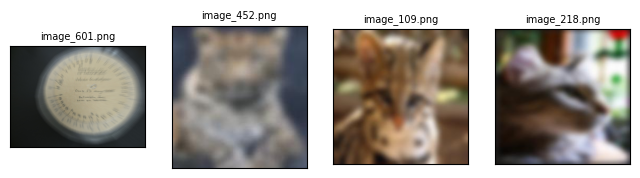

In [ ]:
imagelab.visualize(image_files=blurry_image_files[:4])

The `imagelab.visualize()` also allows you can use to see examples of specific issues in your dataset. `num_images` and `cell_size` are optional arguments, that you can use to control number of examples of each issue type and size of each image in the grid respectively.

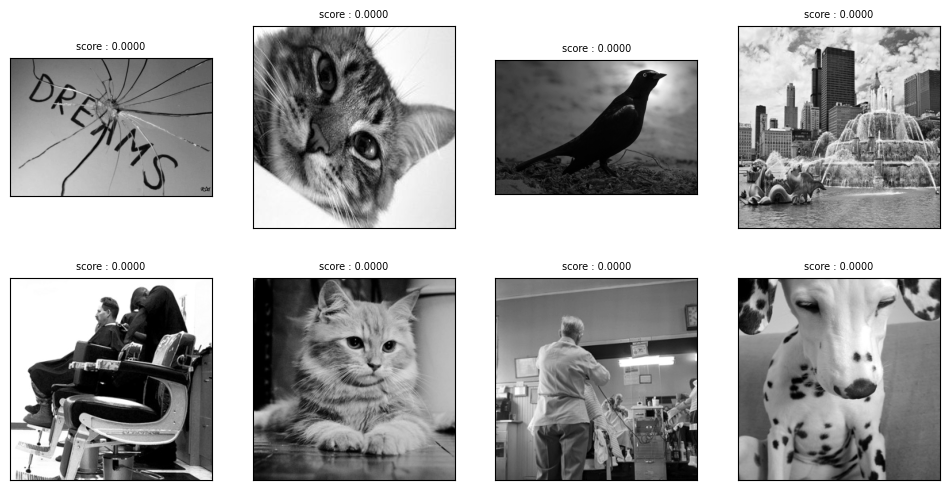

In [ ]:
issue_types = ["grayscale"]
imagelab.visualize(issue_types=issue_types, num_images=8, cell_size=(3, 3))

### `imagelab.info`


This is a **nested dictionary** containing statistics about the images and other miscellaneous information stored while checking for issues in the dataset Possible keys in this dict are **statistics** and a key corresponding to each issue type

In [ ]:
imagelab.info.keys()

dict_keys(['statistics', 'dark', 'light', 'odd_aspect_ratio', 'low_information', 'blurry', 'grayscale', 'odd_size', 'exact_duplicates', 'near_duplicates'])

`imagelab.info['statistics']` is also a dict containing statistics calculated on images that are used for checking for issues in the dataset.

In [ ]:
imagelab.info['statistics'].keys()

dict_keys(['brightness', 'aspect_ratio', 'entropy', 'blurriness', 'color_space', 'size'])

You can see `size` statistics for the dataset below. Here we observe, both the 25th and 75th percentile are 256 for the dataset, hence images that are further away from this range are detected as oddly sized.

In [ ]:
imagelab.info["statistics"]["size"]

,size
count,607.000000
mean,280.830152
std,215.001908
min,32.000000
25%,256.000000
50%,256.000000
75%,256.000000
max,4666.050578


### Duplicate sets

`imagelab.info` can also be used to retrieve which images are near or exact  duplicates of each other. `issue.summary` shows the number of exact duplicate images but does not show how many such *sets* of duplicates images exist in the dataset. To see the number of exact duplicate sets, you can use `imagelab.info`:

In [ ]:
imagelab.info['exact_duplicates']['num_sets']

9

You can also get exactly which images are there in each (exact/near) duplicated set using `imagelab.info`.

In [ ]:
imagelab.info['exact_duplicates']['sets']

[['/content/image_files/image_142.png', '/content/image_files/image_236.png'],
 ['/content/image_files/image_170.png', '/content/image_files/image_299.png'],
 ['/content/image_files/image_190.png', '/content/image_files/image_197.png'],
 ['/content/image_files/image_288.png', '/content/image_files/image_289.png'],
 ['/content/image_files/image_292.png',
  '/content/image_files/image_348.png',
  '/content/image_files/image_491.png'],
 ['/content/image_files/image_30.png', '/content/image_files/image_55.png'],
 ['/content/image_files/image_351.png', '/content/image_files/image_372.png'],
 ['/content/image_files/image_379.png', '/content/image_files/image_577.png'],
 ['/content/image_files/image_548.png', '/content/image_files/image_7.png']]

## Check for an issue with a different threshold

You can use the loaded imagelab instance to check for an issue type with a custom hyperparameter. Here is a table of hyperparameters that each issue type supports and their permissible values:

- `threshold`- All images with scores below this threshold will be flagged as an issue.

- `hash_size` - This controls how much detail about an image we want to keep for getting perceptual hash. Higher sizes imply more detail.

- `hash_type` - Type of perceptual hash to use. Currently `whash` and `phash` are the supported hash types. Check [here](https://github.com/JohannesBuchner/imagehash) for more details on these hash types.

|   | Issue Key        | Hyperparameters                                   |
|---|------------------|---------------------------------------------------|
| 1 | light            | threshold (between 0 and 1)                       |
| 2 | dark             | threshold (between 0 and 1)                       |
| 3 | odd_aspect_ratio | threshold (between 0 and 1)                       |
| 4 | exact_duplicates | N/A                                               |
| 5 | near_duplicates  | hash_size (power of 2), hash_types (whash, phash) |
| 6 | blurry           | threshold (between 0 and 1)                       |
| 7 | grayscale        | threshold (between 0 and 1)                       |
| 8 | low_information  | threshold (between 0 and 1)                       |

Checking for dark images ...
Issue checks completed. 203 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type   |   num_images |
|---:|:-------------|-------------:|
|  5 | dark         |            8 | 

----------------------- dark images ------------------------

Number of examples with this issue: 8
Examples representing most severe instances of this issue:



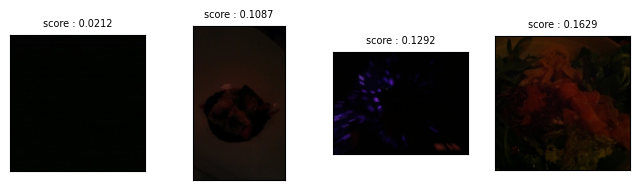

In [ ]:
issue_types = {"dark": {"threshold": 0.2}}
imagelab.find_issues(issue_types)

imagelab.report(issue_types)

Note the number of images with dark issue has reduced from the previous run!

## Save and load

`CleanVision` also has a save and load functionality that you can use to save the results and load them at a later point in time to see results or run more checks. For saving, specify `force=True` to overwrite existing files:

In [ ]:
save_path = "./results"
imagelab.save(save_path)

Saved Imagelab to folder: ./results
The data path and dataset must be not be changed to maintain consistent state when loading this Imagelab


In [ ]:
## For loading a saved instance, specify `dataset_path`
## to help check for any inconsistencies between dataset paths in the previous and current run.
imagelab = Imagelab.load(save_path, dataset_path)

Successfully loaded Imagelab


# 📘 Lable issue with `Cleanlab`

In [ ]:
mnist = fetch_openml("mnist_784")  # Fetch the MNIST dataset

X = mnist.data.astype("float32").to_numpy() # 2D array (images are flattened into 1D)
X /= 255.0  # Scale the features to the [0, 1] range

X = X.reshape(len(X), 28, 28, 1)  # reshape into [N, H, W, C] for Keras
labels = mnist.target.astype("int64").to_numpy()  # 1D array of given labels

## Ensure your classifier is `scikit-learn` compatible

Here, we define a simple neural network with `tf.keras`

In [ ]:
def build_model():
    DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal"
    )
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),  # Define the input shape here
        DefaultConv2D(filters=32, kernel_size=7),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=64),
        DefaultConv2D(filters=64),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=32, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
    return model

As some `cleanlab` features require scikit-learn compatibility, we adapt the above keras neural net accordingly. [scikeras](https://github.com/adriangb/scikeras) is a convenient package that helps with this:

In [ ]:
clf = KerasClassifier(
    model=build_model,
    epochs=10,
    fit__batch_size=32
)

## Compute out-of-sample predicted probabilities

If we'd like `cleanlab` to identify potential label errors in the whole dataset and not just the training set, we can consider using the entire dataset when computing the out-of-sample predicted probabilities, `pred_probs`, via cross-validation.

In [ ]:
num_crossval_folds = 3  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    clf,
    X,
    labels,
    cv=num_crossval_folds,
    method="predict_proba",
)

Epoch 1/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.3607 - loss: 1.7171
Epoch 2/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7288 - loss: 0.7587
Epoch 3/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8009 - loss: 0.5547
Epoch 4/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8250 - loss: 0.4672
Epoch 5/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8383 - loss: 0.4233
Epoch 6/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8492 - loss: 0.3814
Epoch 7/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8567 - loss: 0.3541
Epoch 8/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8683 - loss: 0.3065
Epoch 9/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8736 - loss: 0.2854
Epoch 10/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9153 - loss: 0.2501
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/10
1459/1459 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4071 - l

An additional benefit of cross-validation is that it facilitates more reliable evaluation of our model than a single training/validation split.

In [ ]:
predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(labels, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.9887142857142858


## Use `cleanlab` to find label issues

Based on the given labels and out-of-sample predicted probabilities, `cleanlab` can quickly help us identify label issues in our dataset. For a dataset with `N` examples from `K` classes, the labels should be a 1D array of length `N` and predicted probabilities should be a 2D (`N x K`) array. Here we request that the indices of the identified label issues be sorted by `cleanlab`’s self-confidence score, which measures the quality of each given label via the probability assigned to it in our model’s prediction.

In [ ]:
ranked_label_issues = find_label_issues(
    labels,
    pred_probs,
    return_indices_ranked_by="self_confidence",
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Top 15 most likely label errors: \n {ranked_label_issues[:15]}")

Cleanlab found 286 label issues.
Top 15 most likely label errors: 
 [10994 36446 35851 59915 12183 14008 30604 61681 52210 43109 52981   635
 24457 26560 28357]


`ranked_label_issues()` is a list of indices corresponding to examples that are worth inspecting more closely.

Let’s look at the top 15 examples cleanlab thinks are most likely to be incorrectly labeled. We can see a few label errors and odd edge cases. Feel free to change the values below to display more/fewer examples.

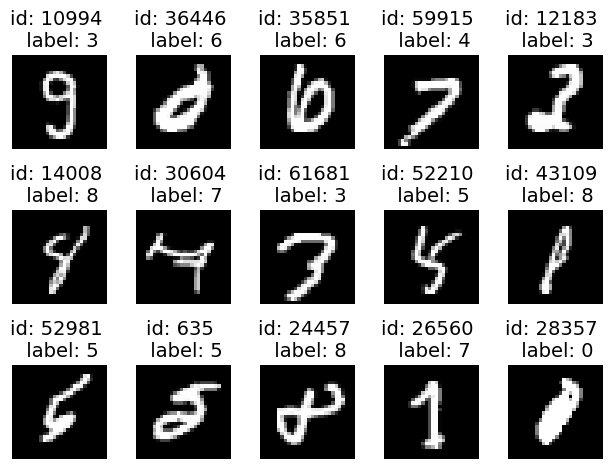

In [ ]:
plot_examples(ranked_label_issues[range(15)], 3, 5)

Let’s zoom into some specific examples from the above set:

Given label is 3 but looks more like a 9:

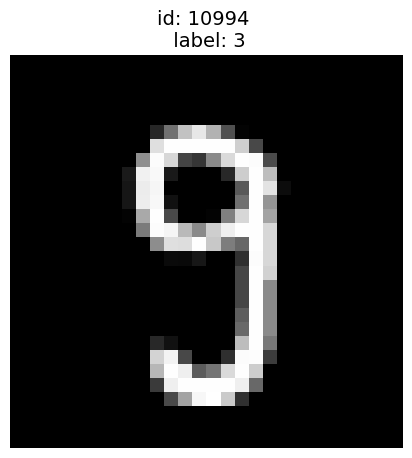

In [ ]:
plot_examples([10994])

Given label is 5 but looks more like a 3:

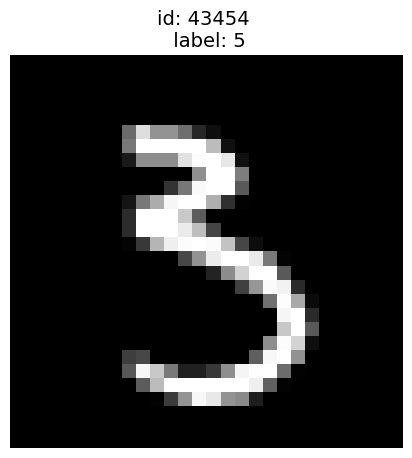

In [ ]:
plot_examples([43454])

A very odd looking 2:

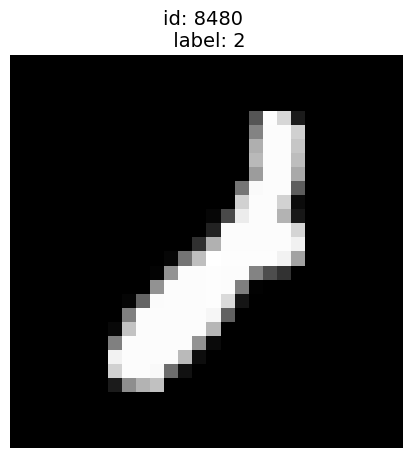

In [ ]:
plot_examples([8480])

`cleanlab` has shortlisted the most likely label errors to speed up your data cleaning process. With this list, you can decide whether to fix label issues or prune some of these examples from the dataset.

# 📘 References

1. [https://github.com/ageron/handson-ml3/](https://github.com/ageron/handson-ml3/)
2. [https://github.com/fchollet/deep-learning-with-python-notebooks](https://github.com/fchollet/deep-learning-with-python-notebooks)

3. [https://github.com/cleanlab/cleanlab](https://github.com/cleanlab/cleanlab)

4. [https://github.com/cleanlab/cleanvision](https://github.com/cleanlab/cleanvision)